# **IMDB REVIEW CLASSIFICATION USING RNN AND LSTM**

In [2]:
! pip install -q tensorflow_datasets

In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

In [4]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [5]:
#Download Data
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
for example, label in train_dataset.take(1):
    print(f'Text: {example.numpy()} \n')
    print(f'Label: {label.numpy()} \n')
    print("---")

Text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it." 

Label: 0 

---


In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
#print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [8]:
for example, label in train_dataset.take(1):
    print(f"Texts : {example.numpy()[:3]} \n")
    print(f"Labels: {label.numpy()[:3]} \n")
    print("----")

Texts : [b'The majority of Stephen King\'s short stories are little gems, with original ideas that don\'t take a long time to develop; basically lean and mean--he sets them up quickly in a scarce number of pages, you read \'em, and you\'re finished before you know you\'ve begun. They\'re like the equivalent of a carton of McDonald\'s fries--they taste Really good and you know there\'s not much nutritional value in them (re: from a literary standpoint, they don\'t say much about the universal human condition), but you\'re still gonna scarf \'em down, just don\'t be a pig and go for the extra-super-sized portion and fill up on too much grease ("too much grease" is a metaphor for the prose in King\'s novels when find yourself reading one of them and saying come on--enough with the pop-cultural observations or clever Yankee asides--get on with the story already!) He has compiled four books of short story collections. I\'ve read them all--from NightShift to the latest, Everything\'s Eventua

Text Encoder
Here we process raw train data into tokens.

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())

In [10]:
vocab

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be',
       'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so',
       'like', 'her', 'just', 'or', 'about', 'has', 'if', 'out', 'some',
       'there', 'what', 'good', 'when', 'more', 'very', 'even', 'she',
       'my', 'no', 'up', 'would', 'which', 'only', 'time', 'really',
       'story', 'their', 'were', 'had', 'see', 'can', 'me', 'than', 'we',
       'much', 'well', 'been', 'get', 'will', 'into', 'also', 'because',
       'other', 'do', 'people', 'bad', 'great', 'first', 'how', 'most',
       'him', 'dont', 'made', 'then', 'movies', 'make', 'films', 'could',
       'way', 'them', 'any', 'too', 'after', 'characters', 'think',
       'watch', 'two', 'many', 'being', 'seen', 'character', 'never',
       'little', 'acting', 'where', 'plot', 'best', 'love', 'did'

In [17]:
vocab[:20]
#Notice that sentences have variable lengths.
#The TextVectorizers produces a 0 padding up to the maximum lngth available in the dataset.

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

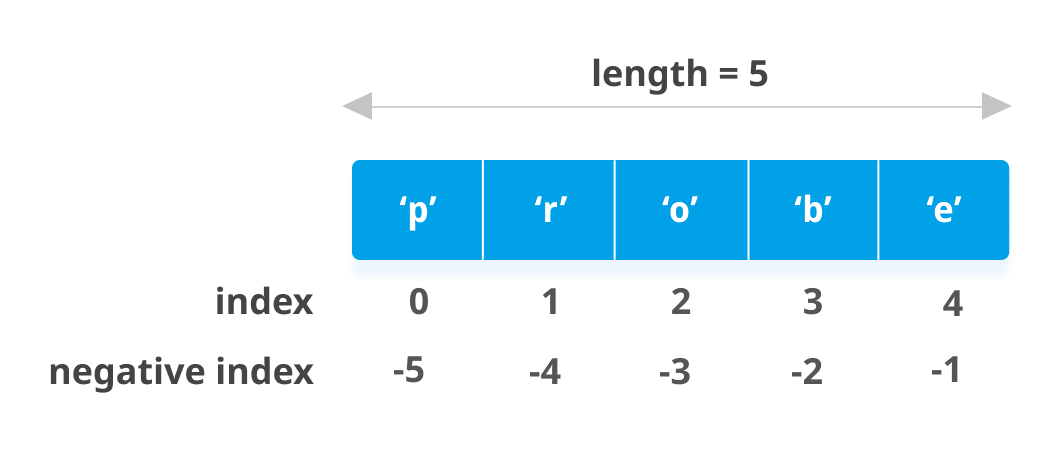

In [18]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2,   1,   5, ...,  38, 234,   1],
       [  4, 267, 163, ...,   0,   0,   0],
       [  8,   2, 350, ...,   0,   0,   0]])

An important thing to notice is that the vectorization is non biyective, since upper cases and punctuationss are removed. Additionally, the size of the vocabulary is small and hence some workds will be tokenized das Unknown by the TextVectorizer

In [19]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The majority of Stephen King\'s short stories are little gems, with original ideas that don\'t take a long time to develop; basically lean and mean--he sets them up quickly in a scarce number of pages, you read \'em, and you\'re finished before you know you\'ve begun. They\'re like the equivalent of a carton of McDonald\'s fries--they taste Really good and you know there\'s not much nutritional value in them (re: from a literary standpoint, they don\'t say much about the universal human condition), but you\'re still gonna scarf \'em down, just don\'t be a pig and go for the extra-super-sized portion and fill up on too much grease ("too much grease" is a metaphor for the prose in King\'s novels when find yourself reading one of them and saying come on--enough with the pop-cultural observations or clever Yankee asides--get on with the story already!) He has compiled four books of short story collections. I\'ve read them all--from NightShift to the latest, Everything\'s Event

# **Create a Model**

We use a very simple model. The model is composed by five Layers in a Sequential flow.



The TextVectorization and Embedding Layers have been explained. In the Bidirectional Layer, we use an RNN. This allows the input to be propagated in both forward and backward directions, generating two outputs that are concatenated at the end, and sent as input for a Dense layer and a final Classifier.

In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# **Compile the Model**
We compile the model. We use the Binary Crossentropy Loss since we are dealing with Binary Classification. We also use the Adam optmizer. We use a smaller learning rate.

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# **Train the Model**

In [22]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 629s 2s/step - loss: 0.6214 - accuracy: 0.5852 - val_loss: 0.4583 - val_accuracy: 0.8198
Epoch 2/10
391/391 [==============================] - 622s 2s/step - loss: 0.3794 - accuracy: 0.8272 - val_loss: 0.3449 - val_accuracy: 0.8411
Epoch 3/10
391/391 [==============================] - 616s 2s/step - loss: 0.3344 - accuracy: 0.8526 - val_loss: 0.3243 - val_accuracy: 0.8458
Epoch 4/10
391/391 [==============================] - 594s 2s/step - loss: 0.3187 - accuracy: 0.8619 - val_loss: 0.3137 - val_accuracy: 0.8719
Epoch 5/10
391/391 [==============================] - 602s 2s/step - loss: 0.3113 - accuracy: 0.8660 - val_loss: 0.3257 - val_accuracy: 0.8474
Epoch 6/10
391/391 [==============================] - 595s 2s/step - loss: 0.3086 - accuracy: 0.8681 - val_loss: 0.2958 - val_accuracy: 0.8687
Epoch 7/10
391/391 [==============================] - 595s 2s/step - loss: 0.3034 - accuracy: 0.8694 - val_loss: 0.3078 - val_accuracy: 0.8729

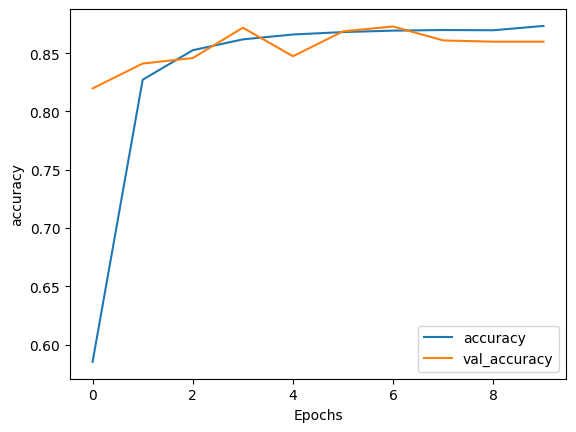

In [23]:
plot_graphs(history, "accuracy")

Evaluation

We evaluate the model on the test set to obtain the best loss and accuracy values.

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 142s 362ms/step - loss: 0.3158 - accuracy: 0.8640
Test Loss: 0.31577053666114807
Test Accuracy: 0.8640000224113464


In [27]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 0s 124ms/step


array([[0.7150849]], dtype=float32)

In [25]:
sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 3s 3s/step
[[-1.5674429]]


**Stacking two or more LSTM**

Recurrent Layers have the option to return sequences. This means that the output for each neuron is returned, and not just the last one (a 2D tensor of shape (batch_size, output_feature)).

If we return the sequences, we obtain a 3D tensor of shape (batch_size, time_steps, output_features). This can be given as input for consective RNNs, since it has 3 axes as the input.

In [28]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [30]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1257s 3s/step - loss: 0.6357 - accuracy: 0.5749 - val_loss: 0.4286 - val_accuracy: 0.8198
Epoch 2/10
391/391 [==============================] - 1227s 3s/step - loss: 0.3862 - accuracy: 0.8262 - val_loss: 0.3639 - val_accuracy: 0.8510
Epoch 3/10
391/391 [==============================] - 1231s 3s/step - loss: 0.3372 - accuracy: 0.8537 - val_loss: 0.3225 - val_accuracy: 0.8693
Epoch 4/10
391/391 [==============================] - 1214s 3s/step - loss: 0.3223 - accuracy: 0.8621 - val_loss: 0.3091 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 1207s 3s/step - loss: 0.3155 - accuracy: 0.8652 - val_loss: 0.3196 - val_accuracy: 0.8651
Epoch 6/10
391/391 [==============================] - 1220s 3s/step - loss: 0.3122 - accuracy: 0.8682 - val_loss: 0.3188 - val_accuracy: 0.8510
Epoch 7/10
391/391 [==============================] - 1237s 3s/step - loss: 0.3080 - accuracy: 0.8680 - val_loss: 0.2992 - val_accuracy:

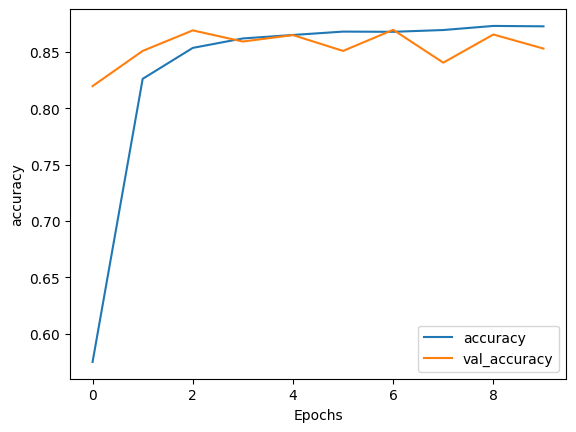

In [31]:
plot_graphs(history, "accuracy")

In [32]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 262s 669ms/step - loss: 0.3225 - accuracy: 0.8594
Test Loss: 0.32248085737228394
Test Accuracy: 0.8593999743461609


In [33]:
sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 8s 8s/step
[[-1.8599877]]


In [34]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 0s 24ms/step


array([[0.11958154]], dtype=float32)

[Reference](https://www.kaggle.com/code/amvillalobos/rnn-text-classification)